<a href="https://www.kaggle.com/code/seeingoh/pay-back-your-money?scriptVersionId=291606368" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries & Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [7]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [8]:
from scipy.optimize import minimize

In [9]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

# EDA

In [10]:
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [11]:
print('df_train.shape:', df_train.shape)
print('df_test.shape:', df_test.shape)

df_train.shape: (593994, 13)
df_test.shape: (254569, 12)


In [ ]:
print(df_train.info())

In [ ]:
print(df_test.info())

### No nulls exist.

In [ ]:
print(df_train.describe())

In [ ]:
cols = ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back']

In [ ]:
for col in cols:
    print(col, df_train[col].nunique())

In [ ]:
cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
num_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

## Target Distribution Visualization

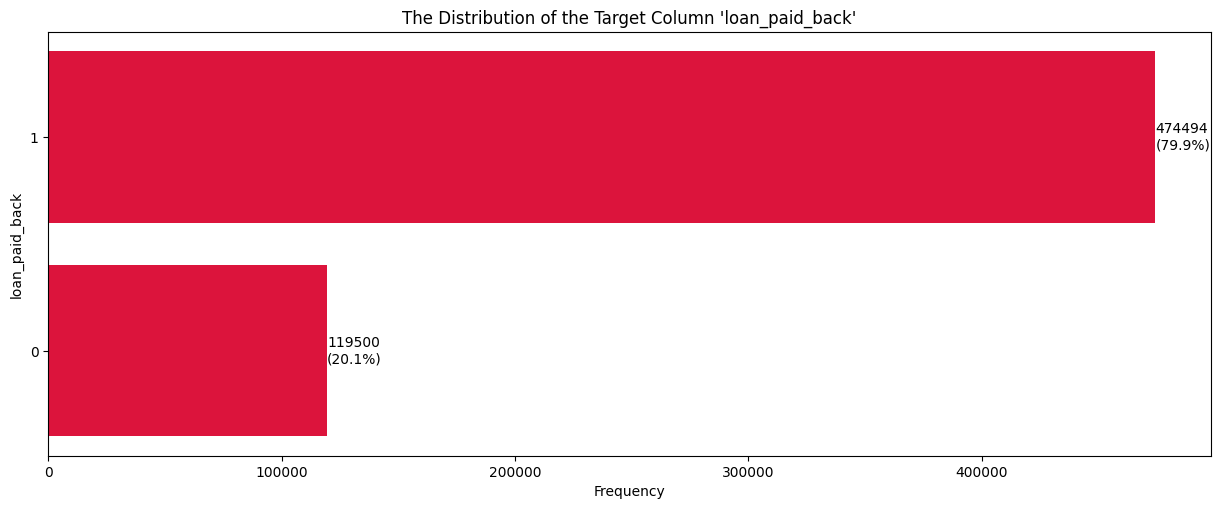

In [12]:
counts = df_train['loan_paid_back'].value_counts()
labels = counts.index
values = counts.values

plt.figure(figsize=(15,5.5)) 

bars = plt.barh(labels, values, color = 'crimson')
plt.ylabel("loan_paid_back")
plt.xlabel("Frequency")
plt.title("The Distribution of the Target Column 'loan_paid_back'")


plt.yticks([1, 0])

total = values.sum()
for bar, count in zip(bars, values):
    width = bar.get_width()
    pct = count / total * 100
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f"{count}\n({pct:.1f}%)",
             ha='left', va='center')
plt.show()

### pay off : default = 8 : 2

## Continuous Variable Distribution Visualization

In [ ]:
n_vars = len(num_cols)
fig, axes = plt.subplots(n_vars, 2, figsize=(12, n_vars * 3))

for i, col in enumerate(num_cols):

    axes[i, 0].hist(df_train[col], bins=60, edgecolor='black', color = 'crimson')
    axes[i, 0].set_title(f"{col}'s Histogram")
    
    axes[i, 1].boxplot(df_train[col], vert=False)
    axes[i, 1].set_title(f"{col}'s Boxplot")

plt.tight_layout()
plt.show()

### There seem to be many outliers.

In [ ]:
n_vars = len(num_cols)
n_cols = 2 
n_rows = (n_vars + 1) // 2  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows)) 

for i, col in enumerate(num_cols):
    row = i // 2  
    col_idx = i % 2  
    sns.boxplot(x='loan_paid_back', y=col, data=df_train, ax=axes[row, col_idx], palette='pastel')
    axes[row, col_idx].set_title(f"{col} by loan_paid_back")

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows-1, 1])

plt.tight_layout()
plt.show()

## Categorical Variable Distribution Visualization

In [ ]:
n_vars = len(cat_cols)
fig, axes = plt.subplots(n_vars, 2, figsize=(14, n_vars * 5))

for i, col in enumerate(cat_cols):
    sns.countplot(x=df_train[col], ax=axes[i, 0],
                  order=df_train[col].value_counts().index,
                  palette='pastel')
    axes[i, 0].set_title(f"{col}'s Countplot")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].tick_params(axis='x', rotation=45)

    df_train[col].value_counts().plot.pie(
        ax=axes[i, 1],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette('pastel'),
        legend=False,
        ylabel='' 
    )
    axes[i, 1].set_title(f"{col}'s Pie Chart")

plt.tight_layout()
plt.show()

In [ ]:
n_vars = len(cat_cols)
n_cols = 2
n_rows = (n_vars + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

for i, col in enumerate(cat_cols):
    row = i // 2
    col_idx = i % 2
    sns.countplot(x=col, hue='loan_paid_back', data=df_train, ax=axes[row, col_idx], palette='pastel')
    axes[row, col_idx].set_title(f"{col} by loan_paid_back")
    axes[row, col_idx].tick_params(axis='x', rotation=45)
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Count')

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows - 1, 1])

plt.tight_layout()
plt.show()

In [ ]:
n_vars = len(cat_cols)
n_cols = 2
n_rows = (n_vars + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

for i, col in enumerate(cat_cols):
    row = i // 2
    col_idx = i % 2

    ratio = (
        df_train.groupby(col)['loan_paid_back']
        .value_counts(normalize=True)
        .rename('ratio')
        .mul(100)
        .reset_index()
    )

    ratio = ratio[ratio['loan_paid_back'] == 0]

    sns.barplot(
        data=ratio,
        x=col,
        y='ratio',
        ax=axes[row, col_idx],
        palette='pastel'
    )

    axes[row, col_idx].set_title(f"{col}: % Not Paid Back")
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('% Not Paid Back')
    axes[row, col_idx].tick_params(axis='x', rotation=45)
    axes[row, col_idx].bar_label(axes[row, col_idx].containers[0], fmt='%.1f%%', label_type='edge', fontsize=9)

if n_vars % 2 != 0:
    fig.delaxes(axes[n_rows - 1, 1])

plt.tight_layout()
plt.show()

### On average, 20.1% of borrowers failed to repay their loans. Features that showed moderate deviations from this average were **education** and **loan purpose**, while those with large deviations were **employment status** and **grade_subgrade**.


# Preprocessing

In financial data, outliers can also be a characteristic of customers, so the difference before and after removal is minimal, so we proceed without removing outliers.

In [ ]:
def feature_engineering(df, train_stats=None):
    df = df.copy()
    
    if 'annual_income' in df.columns:
        df['annual_income_log'] = np.log1p(df['annual_income'])
        
    if 'debt_to_income_ratio' in df.columns:
        if train_stats is None:
            upper_limit = df['debt_to_income_ratio'].quantile(0.99)
            train_stats = {'dti_99': upper_limit}
        else:
            upper_limit = train_stats['dti_99']
        df['debt_to_income_ratio_capped'] = df['debt_to_income_ratio'].clip(upper=upper_limit)

    if "debt_to_income_ratio" in df.columns and "interest_rate" in df.columns:
        df["dti_to_interest_rate"] = df["debt_to_income_ratio"] / (df["interest_rate"] + 1e-6)
        
    return df, train_stats

In [ ]:
def get_preprocessor(model_type, num_cols, cat_cols):

    num_transformer = StandardScaler()
    
    if model_type == 'catboost':
        cat_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    else:
        cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols) 
        ],
        remainder='drop' 
    )
    return preprocessor

In [ ]:
df_train_fe, train_stats = feature_engineering(df_train)

df_test_fe, _ = feature_engineering(df_test, train_stats=train_stats)

In [ ]:
df_train_fe.head()

In [ ]:
df_test_fe.head()

# Modeling

In [ ]:
rs = 42

In [ ]:
def prepare_data(df_train, target_col, num_cols, cat_cols):
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=rs, stratify=y
    )
    
    num_transformer = StandardScaler()
    onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('onehot', onehot_transformer, cat_cols) 
        ],
        remainder='drop' 
    )
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    
    return X_train_processed, X_val_processed, y_train, y_val, preprocessor

In [ ]:
def optimize_single_model(X, y, model_name):
    def objective(trial):
        scale_weight = 4.0 
        
        if model_name == "catboost":
            params = {
                'iterations': trial.suggest_int('iterations', 500, 1200),
                'depth': trial.suggest_int('depth', 4, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
                'scale_pos_weight': scale_weight,
                'random_state': rs,
                'verbose': 0,
                'allow_writing_files': False
            }
            model = CatBoostClassifier(**params)
            
        elif model_name == "lgbm":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 500, 1200),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
                "num_leaves": trial.suggest_int("num_leaves", 20, 100),
                "max_depth": trial.suggest_int("max_depth", 4, 12),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "scale_pos_weight": scale_weight,
                "random_state": rs,
                "verbose": -1
            }
            model = lgb.LGBMClassifier(**params)
            
        elif model_name == "xgb":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 500, 1200),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
                "max_depth": trial.suggest_int("max_depth", 4, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "scale_pos_weight": scale_weight,
                "random_state": rs,
                "use_label_encoder": False,
                "eval_metric": "auc"
            }
            model = xgb.XGBClassifier(**params)

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs)
        scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    return study.best_trial.params

def train_best_model(X_train, y_train, model_type):
    print(f"\n🔍 Optimizing {model_type} with Optuna...")
    best_params = optimize_single_model(X_train, y_train, model_type)
    
    print(f"✅ {model_type} Best Params Found. Training...")
    if model_type == "catboost":
        model = CatBoostClassifier(**best_params, scale_pos_weight=4.0, random_state=rs, verbose=0, allow_writing_files=False)
    elif model_type == "lgbm":
        model = lgb.LGBMClassifier(**best_params, scale_pos_weight=4.0, random_state=rs)
    elif model_type == "xgb":
        model = xgb.XGBClassifier(**best_params, scale_pos_weight=4.0, random_state=rs, eval_metric="auc")
        
    model.fit(X_train, y_train)
    return model

In [ ]:
def optimize_weights_random_search(models, X_val_list, y_val, n_trials=3000):

    print(f"\n⚖️ Optimizing Ensemble Weights (Random Search {n_trials} trials)...")
    
    # 각 모델의 예측값 미리 계산 (속도 향상)
    preds_list = []
    for i, model in enumerate(models):
        preds_list.append(model.predict_proba(X_val_list[i])[:, 1])
    
    best_auc = 0
    best_weights = [0.33, 0.33, 0.33]
    
    for _ in range(n_trials):
        weights = np.random.dirichlet(np.ones(len(models)), size=1)[0]
        
        final_pred = np.zeros_like(preds_list[0])
        for i, pred in enumerate(preds_list):
            final_pred += pred * weights[i]
            
        score = roc_auc_score(y_val, final_pred)
        if score > best_auc:
            best_auc = score
            best_weights = weights
            
    print(f"✅ Optimal Weights Found: {best_weights}")
    print(f"✅ Best Validation AUC: {best_auc:.5f}")
    return best_weights

def ensemble_predict(models, X_list, weights):
    final_pred_proba = np.zeros(X_list[0].shape[0])
    for i, model in enumerate(models):
        pred = model.predict_proba(X_list[i])[:, 1]
        final_pred_proba += pred * weights[i]
        
    final_pred = (final_pred_proba >= 0.5).astype(float)
    return final_pred, final_pred_proba

# Prediction & Submission

In [ ]:
if __name__ == "__main__":
    print("🚀 Pipeline Start (Refined Version)...")

    try:
        df_train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
        df_test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
        df_sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')
    except:
        df_train, df_test, df_sub = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    if not df_train.empty:
        df_train_fe, train_stats = feature_engineering(df_train)
        df_test_fe, _ = feature_engineering(df_test, train_stats=train_stats)
        
        target_col = 'loan_paid_back'
        X = df_train_fe.drop(columns=[target_col])
        y = df_train_fe[target_col]
        
        X_train_raw, X_val_raw, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=rs, stratify=y
        )
        
        num_cols = ['annual_income_log', 'debt_to_income_ratio_capped', 'credit_score', 'loan_amount', 'interest_rate', 'dti_to_interest_rate']
        cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']

        print("\n--- Processing for CatBoost (Ordinal) ---")
        pre_cat = get_preprocessor('catboost', num_cols, cat_cols)
        X_train_cat = pre_cat.fit_transform(X_train_raw)
        X_val_cat = pre_cat.transform(X_val_raw)
        X_test_cat = pre_cat.transform(df_test_fe)
        
        model_cat = train_best_model(X_train_cat, y_train, 'catboost')

        print("\n--- Processing for LGBM/XGB (One-Hot) ---")
        pre_linear = get_preprocessor('linear', num_cols, cat_cols)
        X_train_lin = pre_linear.fit_transform(X_train_raw)
        X_val_lin = pre_linear.transform(X_val_raw)
        X_test_lin = pre_linear.transform(df_test_fe)
        
        model_lgb = train_best_model(X_train_lin, y_train, 'lgbm')
        model_xgb = train_best_model(X_train_lin, y_train, 'xgb')

        models = [model_cat, model_lgb, model_xgb]
        X_val_list = [X_val_cat, X_val_lin, X_val_lin]
        
        print("\n📊 Validation Set Metrics:")
        for i, model in enumerate(models):
            pred_prob = model.predict_proba(X_val_list[i])[:, 1]
            pred_bin = (pred_prob >= 0.5).astype(int)
            
            auc = roc_auc_score(y_val, pred_prob)
            acc = accuracy_score(y_val, pred_bin)
            model_name = ['CatBoost', 'LightGBM', 'XGBoost'][i]
            print(f"{model_name} - AUC: {auc:.5f}, Accuracy: {acc:.5f}")

        best_weights = optimize_weights_random_search(models, X_val_list, y_val, n_trials=5000)
        
        X_test_list = [X_test_cat, X_test_lin, X_test_lin]
        
        print(f"\nApplying Best Weights: {best_weights}")
        _, y_pred_ensemble = ensemble_predict(models, X_test_list, best_weights)
        
        submission = pd.DataFrame({
            'id': df_sub['id'],
            'loan_paid_back': y_pred_ensemble
        })
        
        save_filename = 'submission_refined_final.csv'
        submission.to_csv(save_filename, index=False)
        print(f"\n✅ Submission Saved: {save_filename}")